In [46]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import joblib
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.ensemble import AdaBoostClassifier

In [47]:
df = pd.read_csv("../datasets_models/data.csv")
comarques_df = pd.read_csv("../comarques.csv")

In [48]:
# x < 6 Nada de lluvia
# 6 < x <= 12 Lluvia debil
# 12 < x <= 90 Lluvia moderada
# 90 < x <= 180 Lluvia fuerte
# 180 < x <= 360 Lluvia muy fuerte
# > 360 Lluvia torrencial

In [49]:
def label_encoder(x):
    if x < 6:
        return 0
    elif 6 < x <= 12:
        return 1
    elif 12 < x <= 90:
        return 2
    elif 90 < x <= 180:
        return 3
    elif 180 < x <= 360:
        return 4
    else:
        return 5

df['precip_encoded'] = df['precip'].apply(label_encoder)

In [50]:
df = df.dropna()
df

,comarca,data_lectura,temp,precip,hume,temp_anterior,precip_anterior,hume_anterior,precip_encoded
1,Alt Penedès,2009-01-02,7.803333,10.7,91.841667,7.972500,0.6,85.850000,1
2,Alt Penedès,2009-01-03,7.153333,4.4,90.591667,7.803333,10.7,91.841667,0
3,Alt Penedès,2009-01-04,5.501667,0.0,82.900000,7.153333,4.4,90.591667,0
4,Alt Penedès,2009-01-05,3.429167,0.2,76.541667,5.501667,0.0,82.900000,0
5,Alt Penedès,2009-01-06,2.607500,6.5,84.466667,3.429167,0.2,76.541667,1
...,...,...,...,...,...,...,...,...,...
37095,Vallès Oriental,2023-07-05,20.505594,0.8,83.839161,21.682639,0.0,75.513889,0
37096,Vallès Oriental,2023-07-06,21.566667,2.3,73.333333,20.505594,0.8,83.839161,0
37097,Vallès Oriental,2023-07-07,23.202083,0.1,61.673611,21.566667,2.3,73.333333,0
37098,Vallès Oriental,2023-07-08,25.474306,0.0,55.194444,23.202083,0.1,61.673611,0


In [51]:
comarques_bcn = comarques_df.comarca.values
comarques_dict = dict()
df = df.dropna()

In [52]:
for comarca in comarques_bcn:
    aux = df[df.comarca == comarca].drop(["precip", "precip_anterior", "comarca"], axis=1)
    comarques_dict[comarca] = aux

In [53]:
comarca = 'Vallès Oriental'

In [54]:
comarques_dict[comarca]["precip_encoded"] = comarques_dict[comarca]["precip_encoded"].astype(str)

# Dividir los datos en características (X) y la columna a predecir (y)
x = comarques_dict[comarca].drop(columns=["data_lectura", "precip_encoded"])
y = comarques_dict[comarca]["precip_encoded"]

In [55]:
comarques_dict[comarca]["precip_encoded"].nunique()

6

In [56]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=47)

In [68]:
rf_model = RandomForestClassifier(n_estimators=100)

ada_model = AdaBoostClassifier(base_estimator=rf_model, n_estimators=50)

ada_model.fit(x_train, y_train)

c:\Users\jairo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


AdaBoostClassifier(base_estimator=RandomForestClassifier(random_state=47))

In [69]:
y_pred = ada_model.predict(x_test)

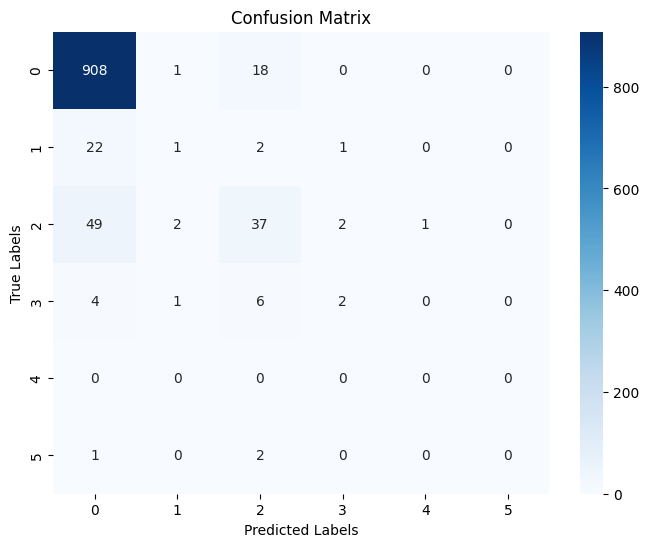

In [70]:
confusion_mat = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [71]:
# Calcular MSE
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# Calcular Accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Calcular Precision
precision = precision_score(y_test, y_pred, average='weighted')
print("Precision:", precision)

# Calcular Recall
recall = recall_score(y_test, y_pred, average='weighted')
print("Recall:", recall)

# Calcular F1-score
f1 = f1_score(y_test, y_pred, average='weighted')
print("F1-score:", f1)

Mean Squared Error: 0.37169811320754714
Accuracy: 0.8943396226415095
Precision: 0.8656626783248965
Recall: 0.8943396226415095
F1-score: 0.8760846909420946


c:\Users\jairo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\jairo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Obtener las probabilidades de predicción en lugar de las etiquetas de clase directamente
y_probs = rf_model.predict_proba(x_test)

# Calcular la curva ROC para cada clase
fpr = dict()
tpr = dict()
roc_auc = dict()

n_classes = len(set(y_train))  # Número de clases

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test == i, y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Calcular el micro-average ROC curve y ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot the ROC curve for each class
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:0.2f})')

# Plot the micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"], label='Micro-average (AUC = {0:0.2f})'.format(roc_auc["micro"]))

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random guessing
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Imprimir el AUC-ROC micro-average
print("AUC-ROC (Micro-average):", roc_auc["micro"])


c:\Users\jairo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
c:\Users\jairo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
c:\Users\jairo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
c:\Users\jairo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
c:\Users\jairo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_ranking.py:1132: Undefined

ValueError: multiclass format is not supported

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

# Obtener las probabilidades de predicción en lugar de las etiquetas de clase directamente
y_probs = rf_model.predict_proba(x_test)

# Calcular la curva Precision-Recall para cada clase
precision = dict()
recall = dict()
average_precision = dict()

n_classes = len(set(y_train))  # Número de clases

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test == i, y_probs[:, i])
    average_precision[i] = average_precision_score(y_test == i, y_probs[:, i])

# Calcular el micro-average Precision-Recall curve y el área bajo la curva PR
precision["micro"], recall["micro"], _ = precision_recall_curve(y_test.ravel(), y_probs.ravel())
average_precision["micro"] = average_precision_score(y_test, y_probs, average="micro")

# Plot the Precision-Recall curve for each class
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(recall[i], precision[i], label=f'Class {i} (AP = {average_precision[i]:0.2f})')

# Plot the micro-average Precision-Recall curve
plt.plot(recall["micro"], precision["micro"], label=f'Micro-average (AP = {average_precision["micro"]:0.2f})')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

# Imprimir el AUC-PR micro-average
print("AUC-PR (Micro-average):", average_precision["micro"])


c:\Users\jairo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_ranking.py:979: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
c:\Users\jairo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_ranking.py:979: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
c:\Users\jairo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_ranking.py:979: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
c:\Users\jairo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_ranking.py:979: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
c:\Users\jairo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_ranking.py:979: UserWarning: No positive class found in y_true

ValueError: multiclass format is not supported

In [10]:
dicc_RF_models = dict()
for comarca in comarques_bcn:
    comarques_dict[comarca]["precip_encoded"] = comarques_dict[comarca]["precip_encoded"].astype(str)

    # Dividir los datos en características (X) y la columna a predecir (y)
    x = comarques_dict[comarca].drop(columns=["data_lectura", "precip_encoded"])
    y = comarques_dict[comarca]["precip_encoded"]

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=47)

    rf_model = RandomForestClassifier(random_state=47)
    rf_model.fit(x_train, y_train)

    y_pred = rf_model.predict(x_test)

    # Calcular Accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)

    # Calcular Precision
    precision = precision_score(y_test, y_pred, average='weighted')
    print("Precision:", precision)

    dicc_RF_models[comarca] = rf_model

joblib.dump(dicc_RF_models, "../models/all_rf_models.pkl")


Accuracy: 0.8924528301886793
Precision: 0.8637612968248367


c:\Users\laiag\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.9084905660377358
Precision: 0.8715007049350746


c:\Users\laiag\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.9245283018867925
Precision: 0.897475592266027


c:\Users\laiag\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.9132075471698113
Precision: 0.8769067394512592


c:\Users\laiag\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.9452830188679245
Precision: 0.9257389028247356


c:\Users\laiag\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.9075471698113208
Precision: 0.8721489712101497


c:\Users\laiag\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.9
Precision: 0.8647076083777285


c:\Users\laiag\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


['../models/all_rf_models.pkl']